In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
import xgboost as xgb
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# 忽略警告
import warnings
warnings.filterwarnings('ignore')
import matplotlib
matplotlib.rcParams['font.sans-serif'] = ['SimHei'] 
matplotlib.rcParams['axes.unicode_minus'] = False

train_data = pd.read_csv('data_C3.csv')

#重命名列名
rename_dict = {
    '温度，oC': '温度',
    '频率，Hz': '频率',
    '磁芯损耗，w/m3': '磁芯损耗',
    '励磁波形': '励磁波形',
    '磁芯材料': '磁芯材料'
}
train_data.rename(columns=rename_dict, inplace=True)

# 转换分类变量为字符串类型
train_data['励磁波形'] = train_data['励磁波形'].astype(str)
train_data['磁芯材料'] = train_data['磁芯材料'].astype(str)



In [2]:
flux_columns = train_data.columns[4:-1]  # 除去前4列和最后一列（磁芯材料）

# 计算时域特征
train_data['flux_mean'] = train_data[flux_columns].mean(axis=1)
train_data['flux_std'] = train_data[flux_columns].std(axis=1)
train_data['flux_min'] = train_data[flux_columns].min(axis=1)
train_data['flux_max'] = train_data[flux_columns].max(axis=1)
train_data['flux_ptp'] = train_data['flux_max'] - train_data['flux_min']  # 峰-峰值
train_data['flux_median'] = train_data[flux_columns].median(axis=1)
train_data['flux_skew'] = train_data[flux_columns].skew(axis=1)
train_data['flux_kurtosis'] = train_data[flux_columns].kurtosis(axis=1)
train_data['flux_rms'] = np.sqrt(np.mean(train_data[flux_columns]**2, axis=1))  # 均方根值

# 定义FFT特征提取函数
def extract_fft_features(row):
    signal = row[flux_columns].values
    fft_coeffs = np.fft.fft(signal)
    fft_mag = np.abs(fft_coeffs)
    fft_freq = np.fft.fftfreq(len(signal))
    pos_mask = fft_freq >= 0
    fft_freq = fft_freq[pos_mask]
    fft_mag = fft_mag[pos_mask]
    
    # 主要频率成分
    dominant_freq = fft_freq[np.argmax(fft_mag)]
    # 频谱能量
    spectral_energy = np.sum(fft_mag**2)
    
    return pd.Series([dominant_freq, spectral_energy])

# 应用FFT特征提取
train_data[['flux_dominant_freq', 'flux_spectral_energy']] = train_data.apply(extract_fft_features, axis=1)

# 删除原始磁通密度列
train_data = train_data.drop(columns=flux_columns)

print("\n提取特征后的训练集数据预览：")
print(train_data.head())


提取特征后的训练集数据预览：
   温度     频率         磁芯损耗 励磁波形 磁芯材料     flux_mean  flux_std  flux_min  \
0  25  50030  1997.955250  正弦波  材料1 -4.003908e-11  0.020410 -0.028840   
1  25  50020  2427.749830  正弦波  材料1 -2.539062e-11  0.022234 -0.031427   
2  25  50020  3332.725760  正弦波  材料1 -9.765699e-13  0.025119 -0.035513   
3  25  50020  4502.908007  正弦波  材料1 -5.859375e-11  0.028277 -0.040025   
4  25  50030  6063.023248  正弦波  材料1  4.101562e-11  0.031828 -0.045085   

   flux_max  flux_ptp  flux_median  flux_skew  flux_kurtosis  flux_rms  \
0  0.028849  0.057689     0.000013  -0.000628      -1.499370  0.020400   
1  0.031419  0.062846     0.000024  -0.001224      -1.499348  0.022223   
2  0.035535  0.071047     0.000016  -0.000495      -1.497841  0.025107   
3  0.040015  0.080041     0.000037  -0.001533      -1.496349  0.028263   
4  0.045028  0.090113     0.000060  -0.002512      -1.496577  0.031812   

   flux_dominant_freq  flux_spectral_energy  
0            0.000977            218.191748  
1       

In [3]:
categorical_features = ['励磁波形', '磁芯材料']
numeric_features = train_data.drop(columns=['磁芯损耗'] + categorical_features).select_dtypes(include=[np.number]).columns.tolist()

# 分离特征和目标变量
X = train_data.drop(['磁芯损耗'], axis=1)
y = train_data['磁芯损耗']



In [4]:
X2=X.drop(['flux_mean','flux_std','flux_ptp','flux_median','flux_kurtosis','flux_skew','flux_dominant_freq'], axis=1)
numeric_features2 = train_data.drop(columns=['磁芯损耗','flux_mean','flux_std','flux_ptp','flux_median','flux_kurtosis','flux_skew','flux_dominant_freq'] + categorical_features).select_dtypes(include=[np.number]).columns.tolist()

In [10]:
X2

,温度,频率,励磁波形,磁芯材料,flux_min,flux_max,flux_rms,flux_spectral_energy
0,25,50030,正弦波,材料1,-0.028840,0.028849,0.020400,218.191748
1,25,50020,正弦波,材料1,-0.031427,0.031419,0.022223,258.933457
2,25,50020,正弦波,材料1,-0.035513,0.035535,0.025107,330.481815
3,25,50020,正弦波,材料1,-0.040025,0.040015,0.028263,418.791954
4,25,50030,正弦波,材料1,-0.045085,0.045028,0.031812,530.591464
...,...,...,...,...,...,...,...,...
12395,90,199190,梯形波,材料4,-0.034180,0.034867,0.021164,234.845407
12396,90,199190,梯形波,材料4,-0.037582,0.038341,0.023316,285.024904
12397,90,199190,梯形波,材料4,-0.047934,0.048877,0.029728,463.346522
12398,90,199190,梯形波,材料4,-0.053880,0.054889,0.033376,584.048187



Linear Regression模型评估指标：
R-squared: 0.6468
MAE: 130476.0848
RMSE: 213006.6417
Accuracy (±10%): 7.38%


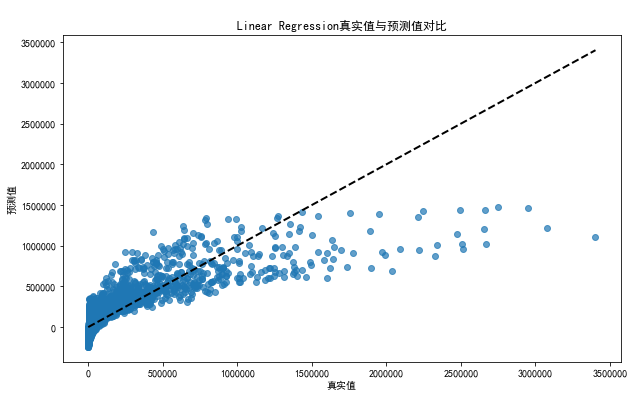


Support Vector Regression模型评估指标：
R-squared: -0.1612
MAE: 176447.3122
RMSE: 386230.3290
Accuracy (±10%): 2.94%


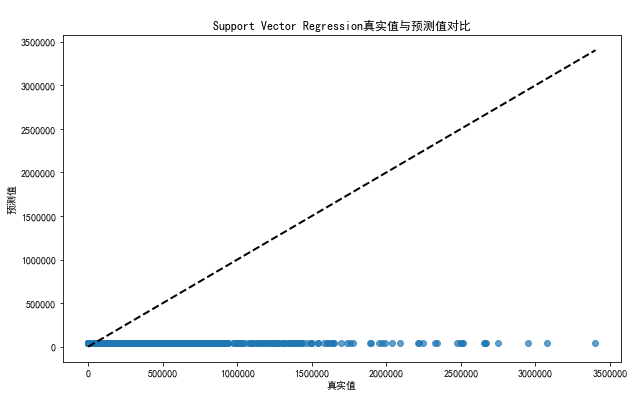


Random Forest模型评估指标：
R-squared: 0.9879
MAE: 15965.8757
RMSE: 39492.3400
Accuracy (±10%): 61.13%


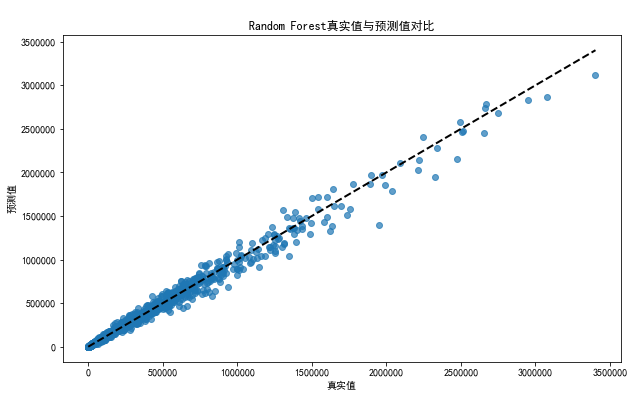


Gradient Boosting模型评估指标：
R-squared: 0.9656
MAE: 34873.1299
RMSE: 66473.8122
Accuracy (±10%): 19.56%


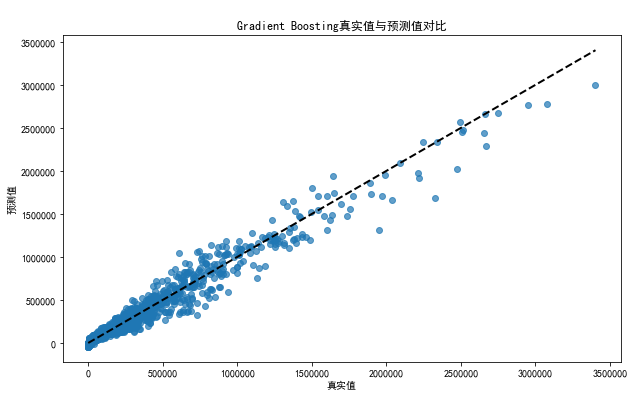


XGBoost模型评估指标：
R-squared: 0.9921
MAE: 13483.1659
RMSE: 31860.9998
Accuracy (±10%): 48.15%


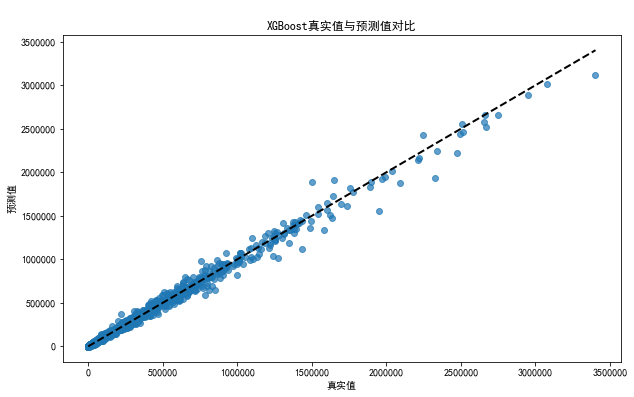


Neural Network模型评估指标：
R-squared: -0.0570
MAE: 161061.7336
RMSE: 368492.7947
Accuracy (±10%): 3.47%


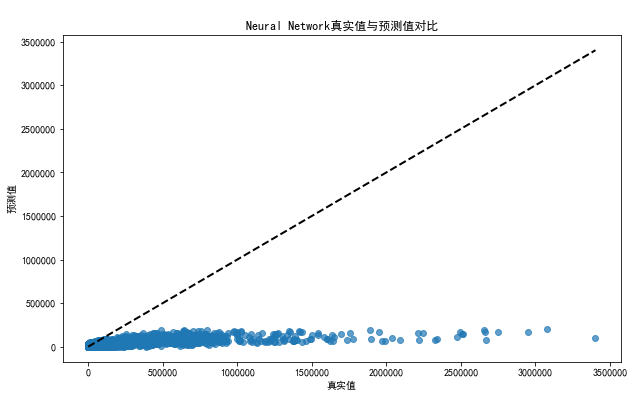


所有模型的评估结果：
                       Model  R-squared            MAE           RMSE  \
0          Linear Regression   0.646830  130476.084766  213006.641738   
1  Support Vector Regression  -0.161157  176447.312208  386230.329012   
2              Random Forest   0.987860   15965.875716   39492.339984   
3          Gradient Boosting   0.965605   34873.129909   66473.812207   
4                    XGBoost   0.992098   13483.165885   31860.999830   
5             Neural Network  -0.056954  161061.733618  368492.794718   

    Accuracy  
0   7.379032  
1   2.943548  
2  61.129032  
3  19.556452  
4  48.145161  
5   3.467742  


In [17]:
# 拆分训练集和测试集
X2_train, X2_test, y_train, y_test = train_test_split(X2, y, test_size=0.2, random_state=42)

# 定义数值型特征的标准化
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# 标签编码
categorical_transformer = Pipeline(steps=[
    ('encoder', OrdinalEncoder())
])

# 预处理器
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features2),
        ('cat', categorical_transformer, categorical_features)
    ])
# 机器学习类型
models = [
    ('Linear Regression', LinearRegression()),
    ('Support Vector Regression', SVR()),
    ('Random Forest', RandomForestRegressor(random_state=42)),
    ('Gradient Boosting', GradientBoostingRegressor(random_state=42)),
    ('XGBoost', xgb.XGBRegressor(random_state=42)),
    ('Neural Network', MLPRegressor(random_state=42))
]
model_results = []
for name, model in models:
    # Pipeline
    clf = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', model)
    ])
    # 训练
    clf.fit(X2_train, y_train)
    # 预测
    y_pred = clf.predict(X2_test)
    # 评估
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    accuracy = np.mean(np.abs((y_pred - y_test) / y_test) < 0.10) * 100
    model_results.append({
        'Model': name,
        'R-squared': r2,
        'MAE': mae,
        'RMSE': rmse,
        'Accuracy': accuracy
    })
    
    print(f"\n{name}模型评估指标：")
    print(f"R-squared: {r2:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"Accuracy (±10%): {accuracy:.2f}%")
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, alpha=0.7)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
    plt.xlabel('真实值')
    plt.ylabel('预测值')
    plt.title(f"\n{name}真实值与预测值对比")
    plt.show()

results_df = pd.DataFrame(model_results)
print("\n所有模型的评估结果：")
print(results_df)

In [12]:
# 按准确度进行降序排序
results_df2 = results_df.sort_values(by='Accuracy', ascending=False)
print("\n模型性能比较：")
print(results_df2)


模型性能比较：
                       Model  R-squared            MAE           RMSE  \
2              Random Forest   0.987860   15965.875716   39492.339984   
4                    XGBoost   0.992098   13483.165885   31860.999830   
3          Gradient Boosting   0.965605   34873.129909   66473.812207   
0          Linear Regression   0.646830  130476.084766  213006.641738   
5             Neural Network  -0.056954  161061.733618  368492.794718   
1  Support Vector Regression  -0.161157  176447.312208  386230.329012   

    Accuracy  
2  61.129032  
4  48.145161  
3  19.556452  
0   7.379032  
5   3.467742  
1   2.943548  


In [13]:
results_df2.to_csv('machine_result2.csv')

In [14]:
# 用随机森林对全部数据进行训练并保存训练模型
rf_final = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
])
rf_final.fit(X2, y)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['温度', '频率', 'flux_min',
                                                   'flux_max', 'flux_rms',
                                                   'flux_spectral_energy']),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OrdinalEncoder())]),
                                                  ['励磁波形', '磁芯材料'])])),
                ('regressor', RandomForestRegressor(random_state=42))])

In [70]:
# 确保测试集的列与训练集一致
test_coded=test_data
missing_cols = set(X2.columns) - set(test_coded.columns)
for col in missing_cols:
    test_coded[col] = 0

# 确保列顺序一致
test_coded = test_coded[X2.columns]

In [71]:
test_predictions = rf_final.predict(test_coded)

In [72]:
test_data['磁芯损耗预测'] = test_predictions.round(1)
print("\n测试集预测结果预览：")
print(test_data[['序号', '磁芯损耗预测']])


测试集预测结果预览：
      序号    磁芯损耗预测
0      1   21448.9
1      2   29224.2
2      3   39456.7
3      4   38742.2
4      5   71901.4
..   ...       ...
395  396    8416.1
396  397   31622.3
397  398  379207.9
398  399  367371.3
399  400    1328.7

[400 rows x 2 columns]


In [73]:
aa = test_data[['序号', '磁芯损耗预测']]
aa.to_csv('C4_pred2.csv', index=False)

In [74]:
# 题目特定样本序号
specific_samples = [16, 76, 98, 126, 168, 230, 271, 338, 348, 379]

# 特定样本的预测结果
specific_predictions = test_data[test_data['序号'].isin(specific_samples)][['序号', '磁芯损耗预测']]
specific_predictions = specific_predictions.reset_index(drop=True)

print("\n特定样本的磁芯损耗预测结果：")
print(specific_predictions)



特定样本的磁芯损耗预测结果：
    序号     磁芯损耗预测
0   16     1064.7
1   76  1831741.6
2   98    16188.4
3  126     1869.8
4  168   105402.4
5  230    69746.2
6  271  1938380.6
7  338    10266.1
8  348   827325.8
9  379     1317.0


In [76]:
specific_predictions.to_csv('specific_predictions.csv')